# EMLDDMM Example: MRICloud atlas data



## Introdution
We run registration between a pair of T1 MRI images from mricloud.org.
Each includes a grayscale image and a set of labels.  We first run the
registration pipeline with a config file. We then run the transformation pipeline.


In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os

import nibabel as nib
import glob

# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

## Registration pipeline
Here we load the atlas and target images, and run multi scale registration.
Note the inputs

atlas_name,label_name,target_name: vtk filenames for images

config_file: json filename for options

output_dir: string containing a directory for outputs


In [2]:
# copied to local directory
atlas_name = 'example_images/mricloud/Adt27-55_02_Adt27-55_02_MNI.vtk'
label_name = 'example_images/mricloud/Adt27-55_02_Adt27-55_02_FullLabels.vtk'
target_name = 'example_images/mricloud/Adt27-55_03_Adt27-55_03_MNI.vtk'

config_file = 'config_mricloud.json'
output_dir = 'mricloud_test_outputs/'

In [3]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

In [4]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

Found extension .vtk
[1. 1. 1.]


<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Atlas image')

In [5]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[1.0, 1.0, 1.0]


In [6]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
W0 = np.ones_like(J[0])

Found extension .vtk
[1. 1. 1.]


<IPython.core.display.Javascript object>

In [7]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

In [8]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Initial transformed atlas')

Found 3 scales
dv tensor([3., 3., 3.], device='cuda:0')
a scale is 4


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


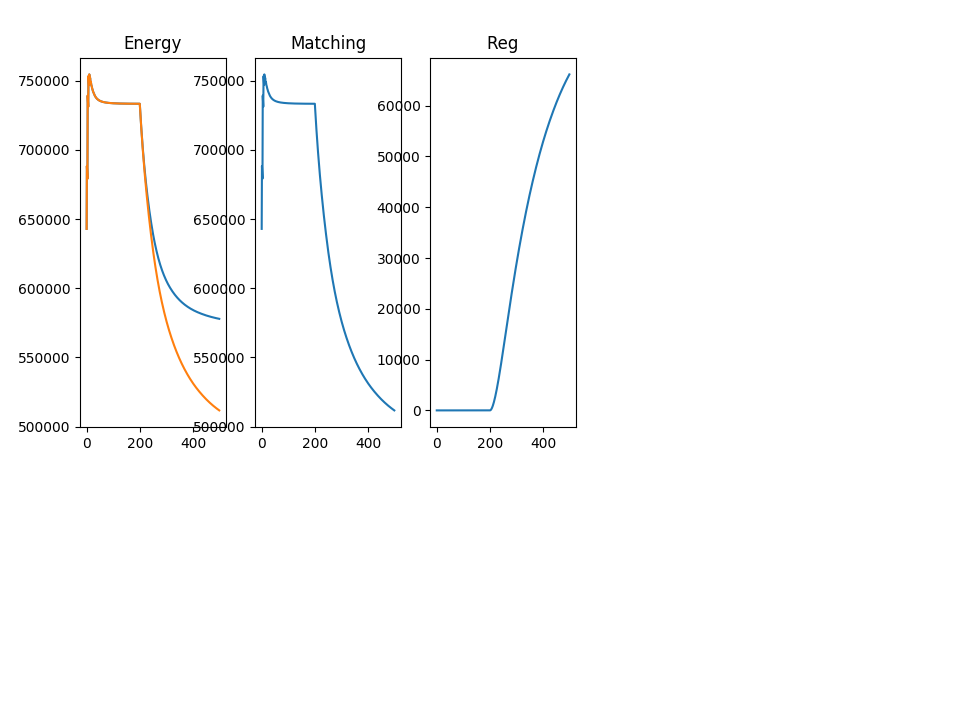

<IPython.core.display.Javascript object>


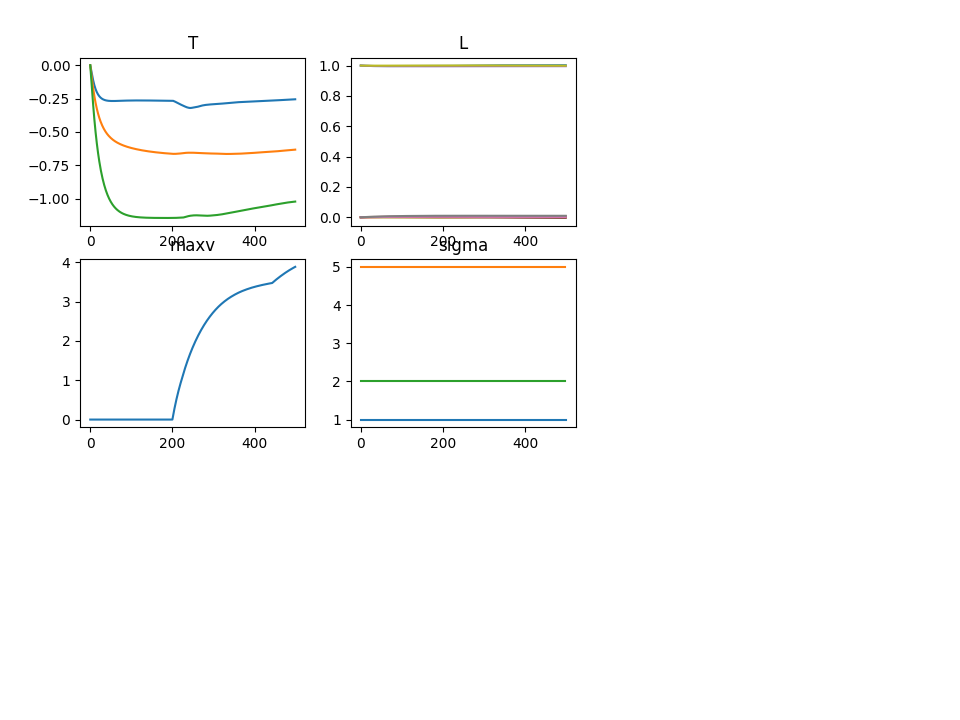

<IPython.core.display.Javascript object>


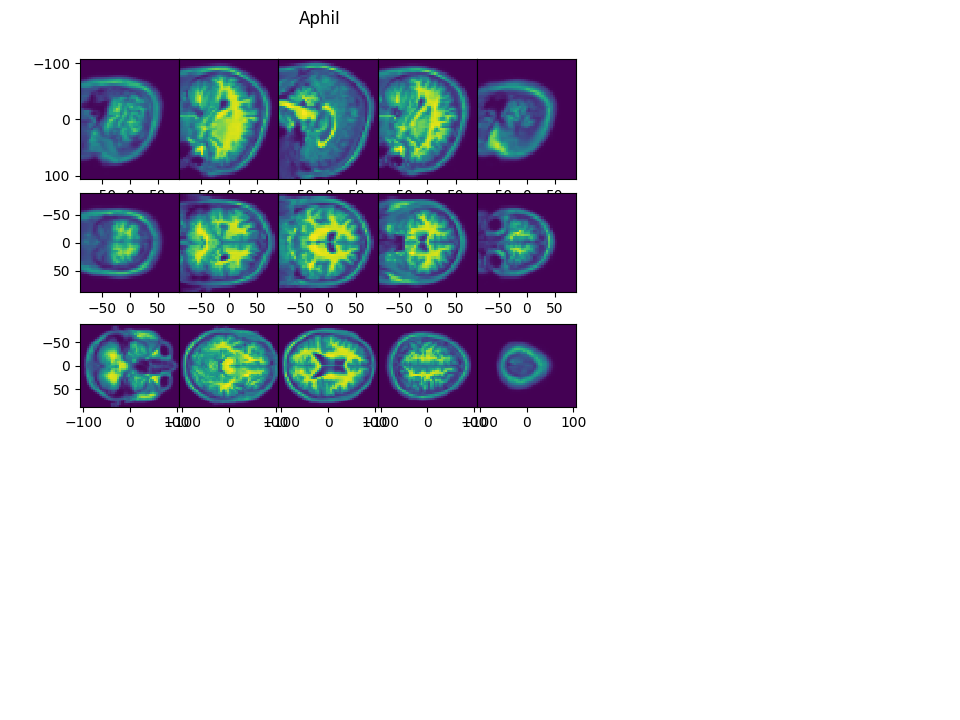

<IPython.core.display.Javascript object>


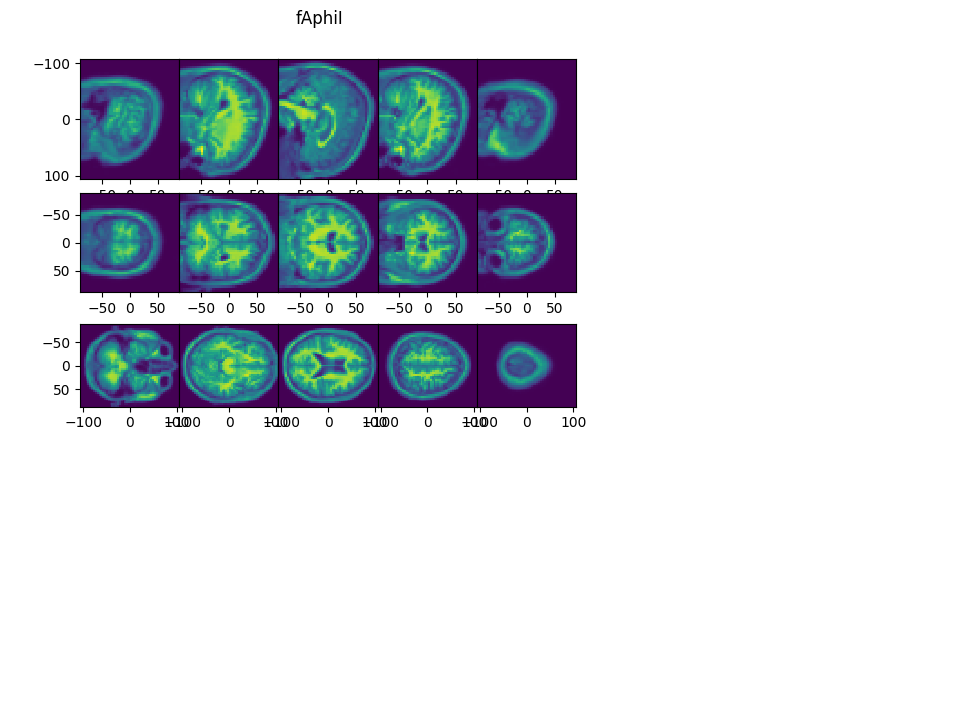

<IPython.core.display.Javascript object>


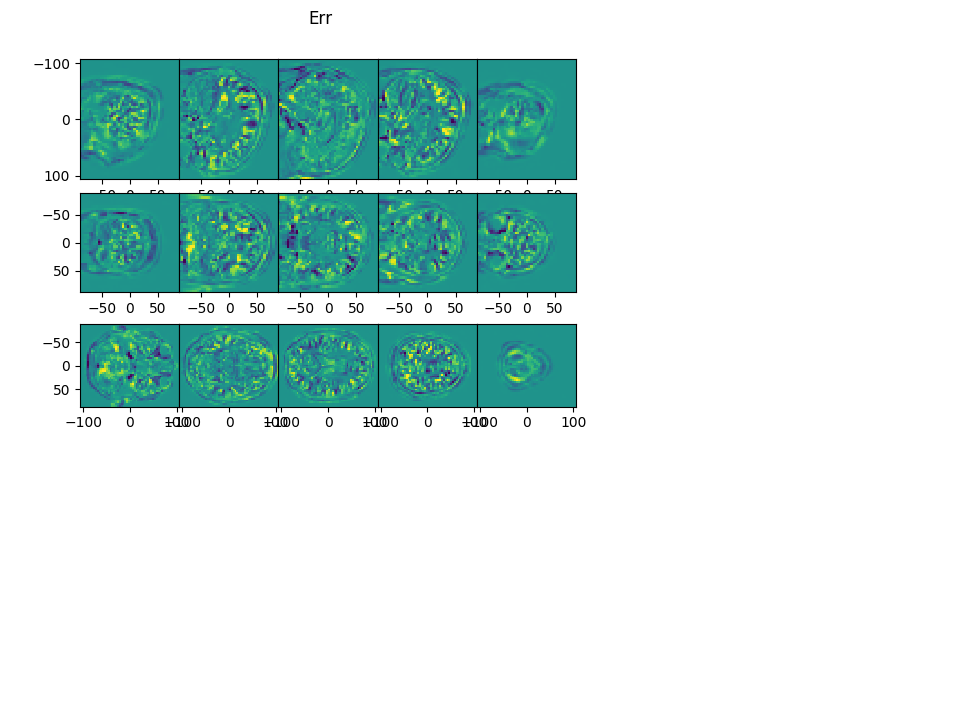

<IPython.core.display.Javascript object>


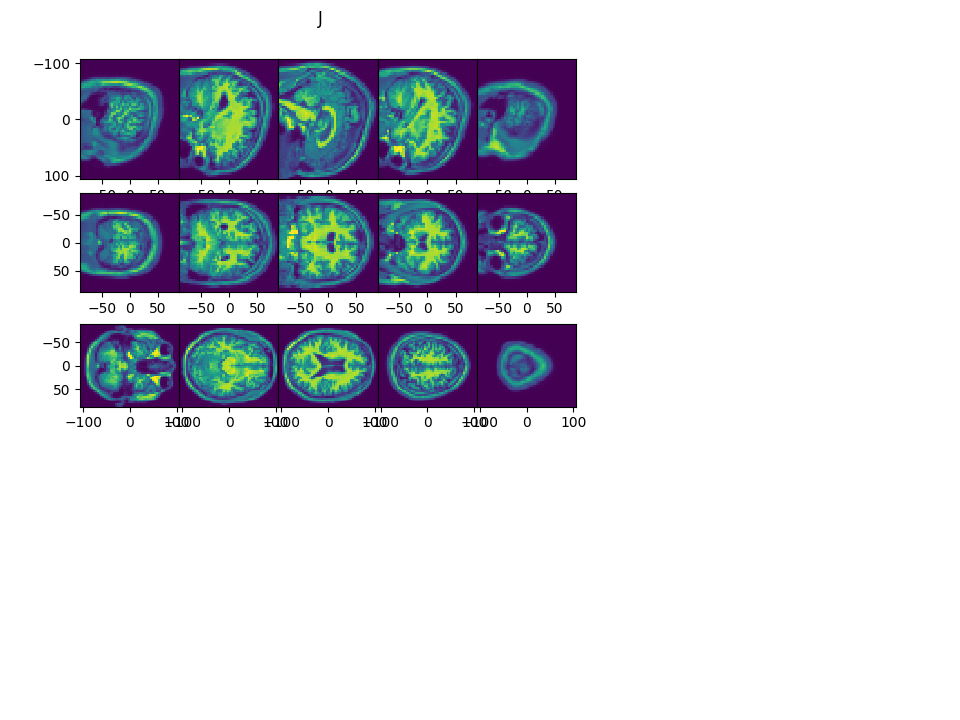

<IPython.core.display.Javascript object>


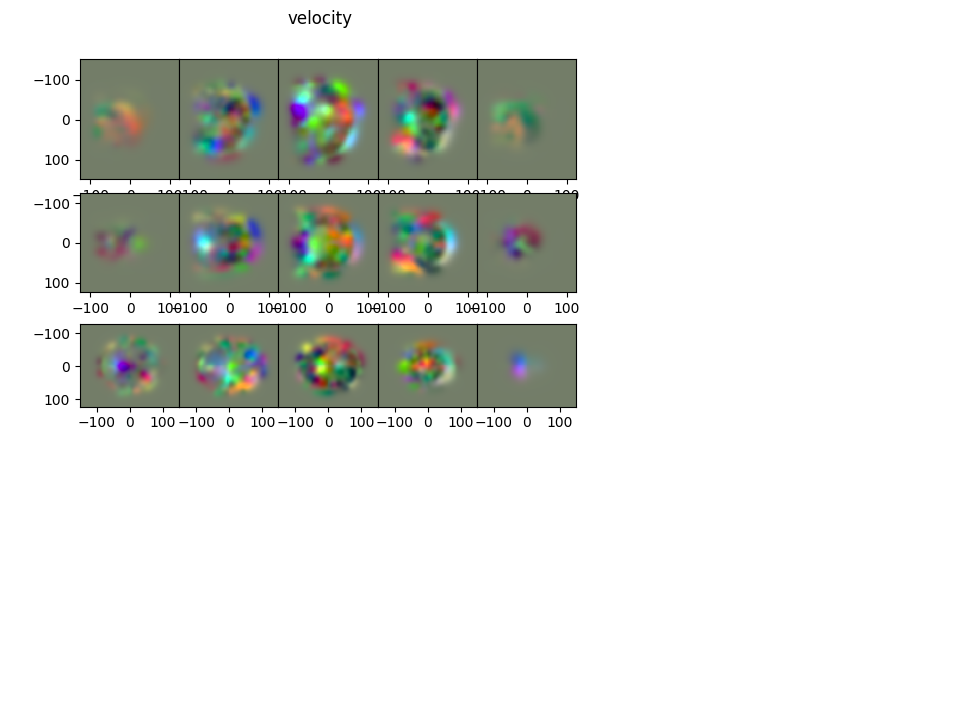

<IPython.core.display.Javascript object>


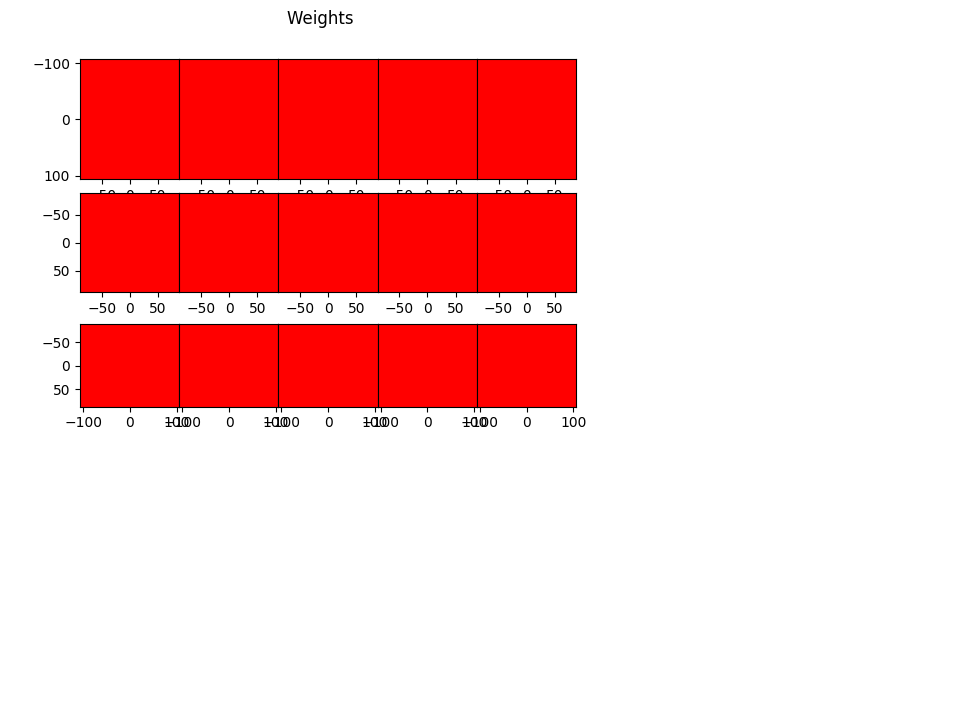

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/mnt/data/csh_data/emlddmm/emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Finished iteration 240
Finished iteration 250
Finished iteration 260
Finished iteration 270
Finished iteration 280
Finished iteration 290
Iteration 300, translation oscilating, reducing eA to 4.5
Finished iteration 300
Finished iteration 310
Finished iteration 320
Iteration 330, translation oscilating, reducing eA to 4.05
Finished iteration 330
Finished iteration 340
Finished iteration 350
Iteration 360, linear oscilating, reducing eA to 3.645
Finished it

/mnt/data/csh_data/emlddmm/emlddmm.py:868: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v,device=device,dtype=dtype)
/mnt/data/csh_data/emlddmm/emlddmm.py:883: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A,device=device,dtype=dtype).detach().clone()


<IPython.core.display.Javascript object>


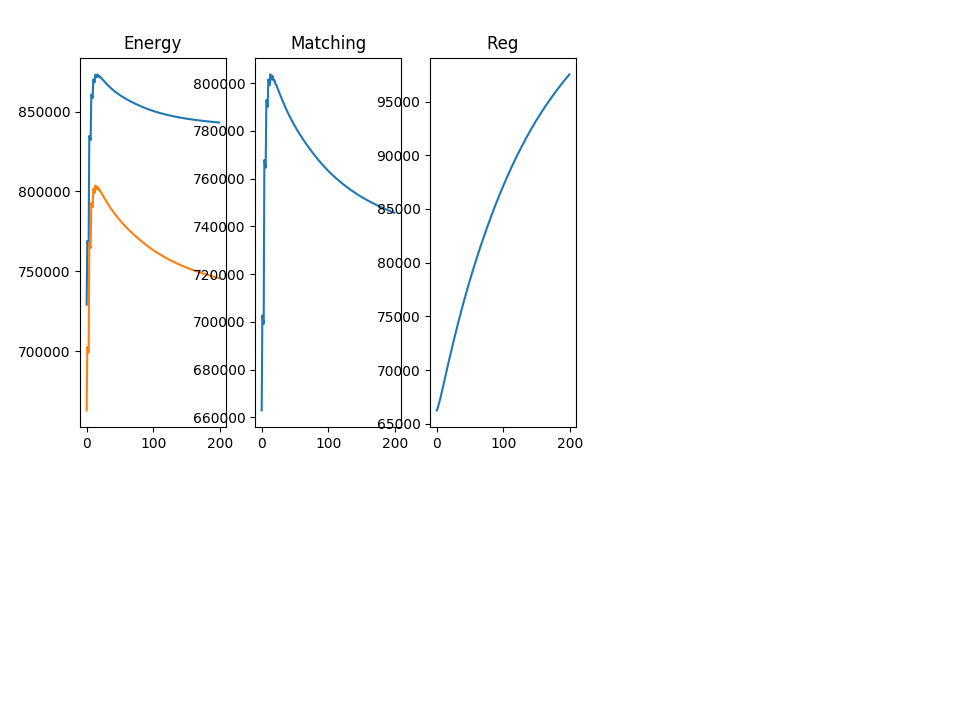

<IPython.core.display.Javascript object>


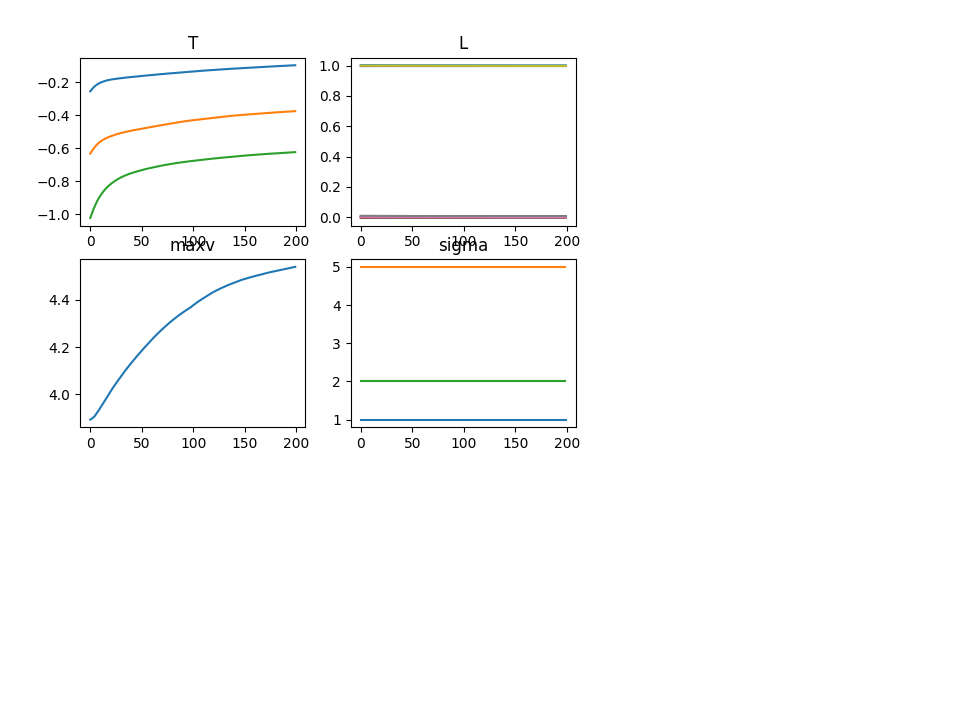

<IPython.core.display.Javascript object>


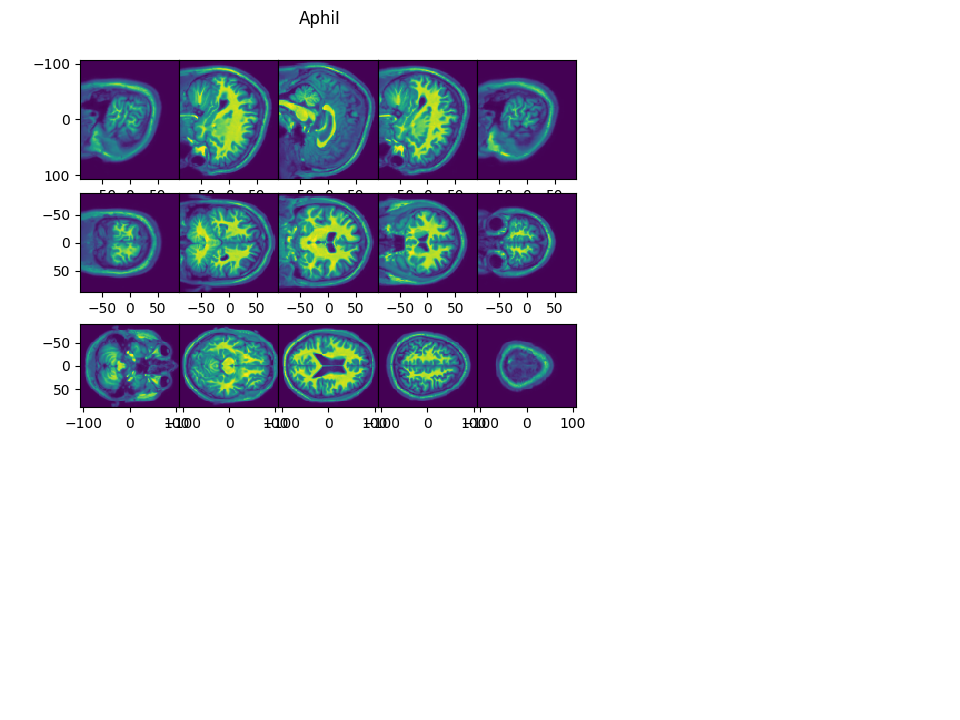

<IPython.core.display.Javascript object>


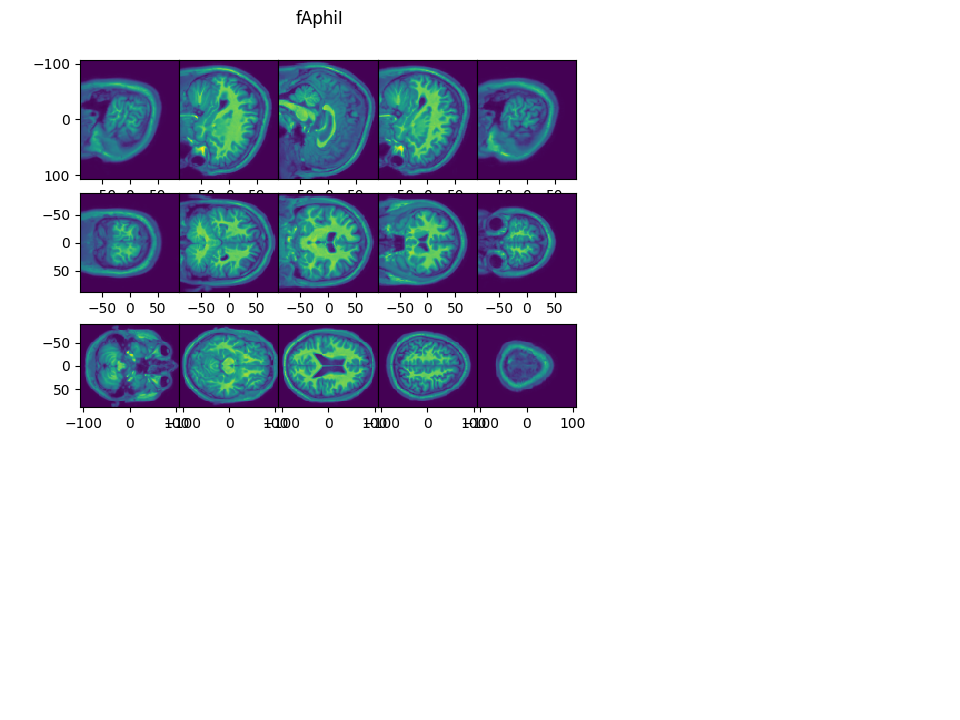

<IPython.core.display.Javascript object>


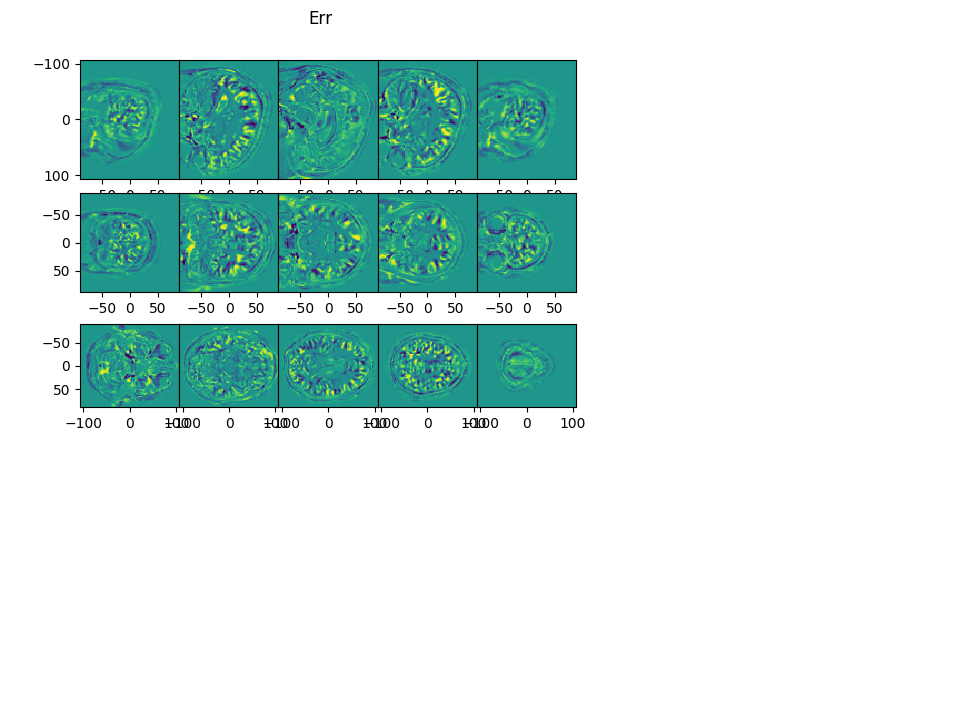

<IPython.core.display.Javascript object>


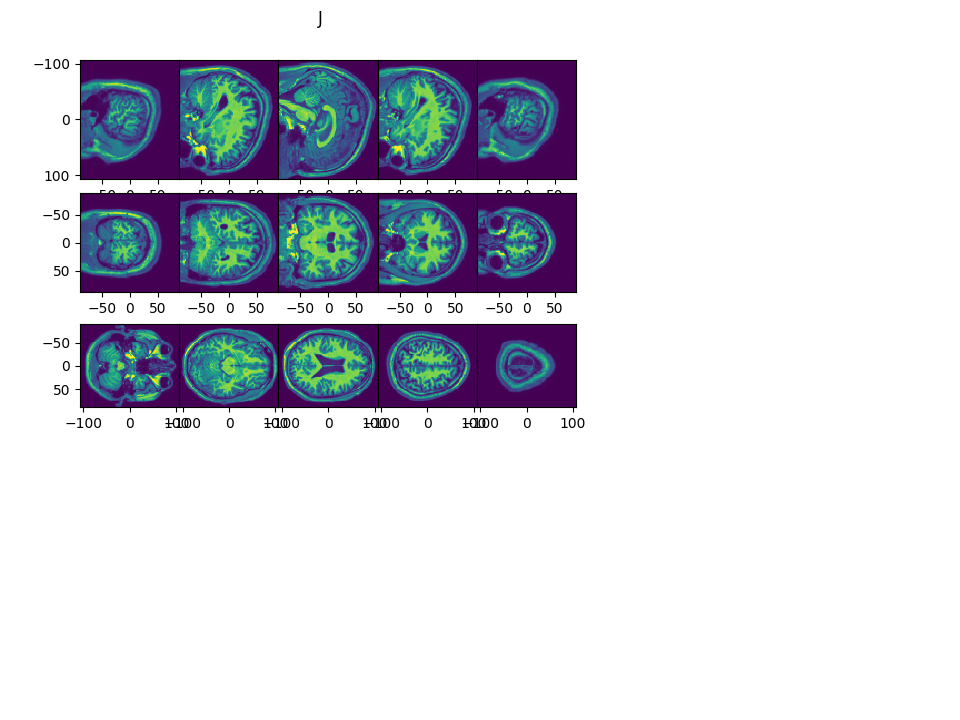

<IPython.core.display.Javascript object>


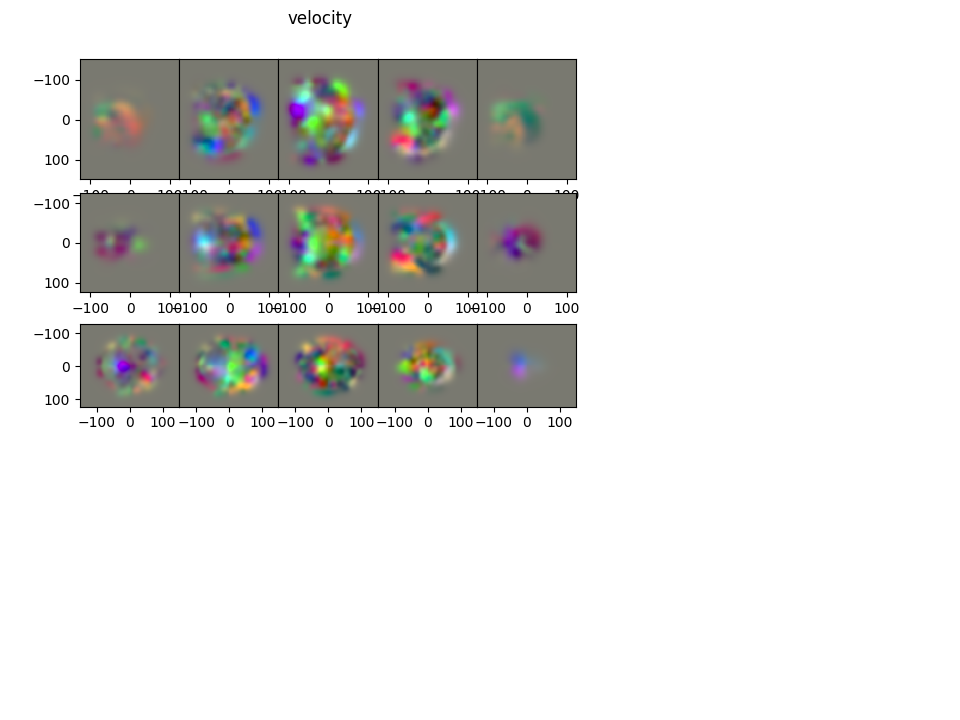

<IPython.core.display.Javascript object>


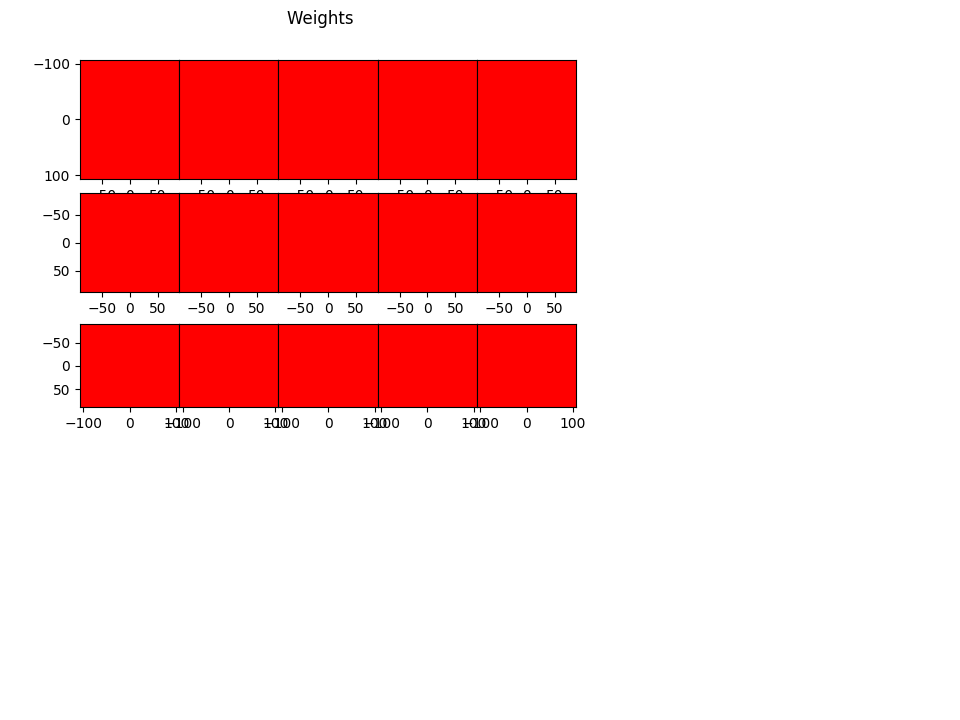

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
dv tensor([3., 3., 3.], device='cuda:0')
a scale is 4


<IPython.core.display.Javascript object>


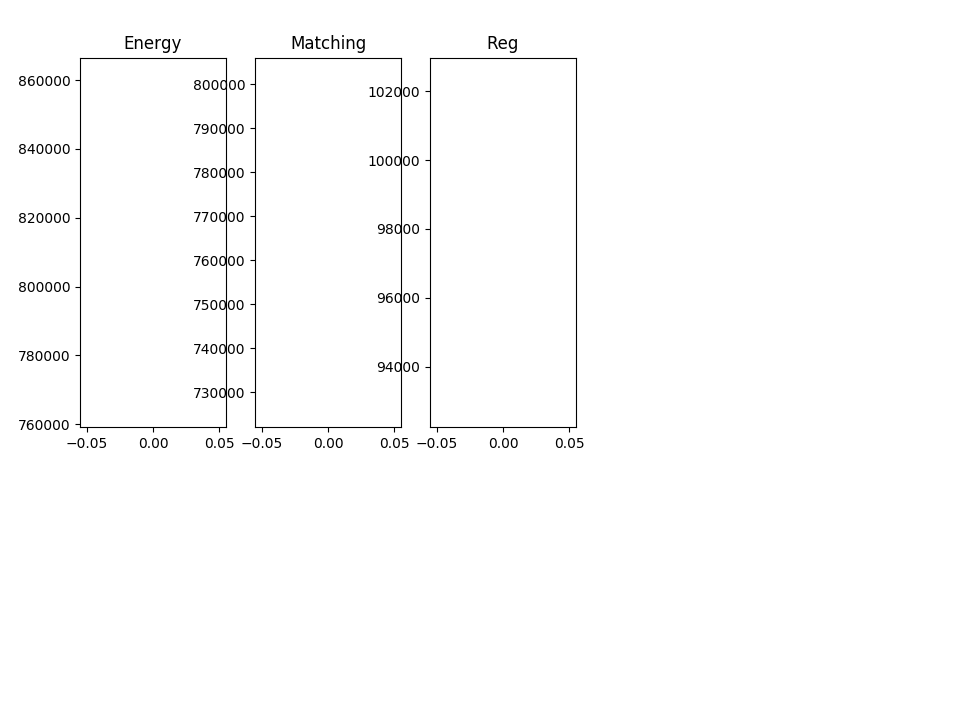

/mnt/data/csh_data/emlddmm/emlddmm.py:931: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figA,axA = plt.subplots(2,2)


<IPython.core.display.Javascript object>


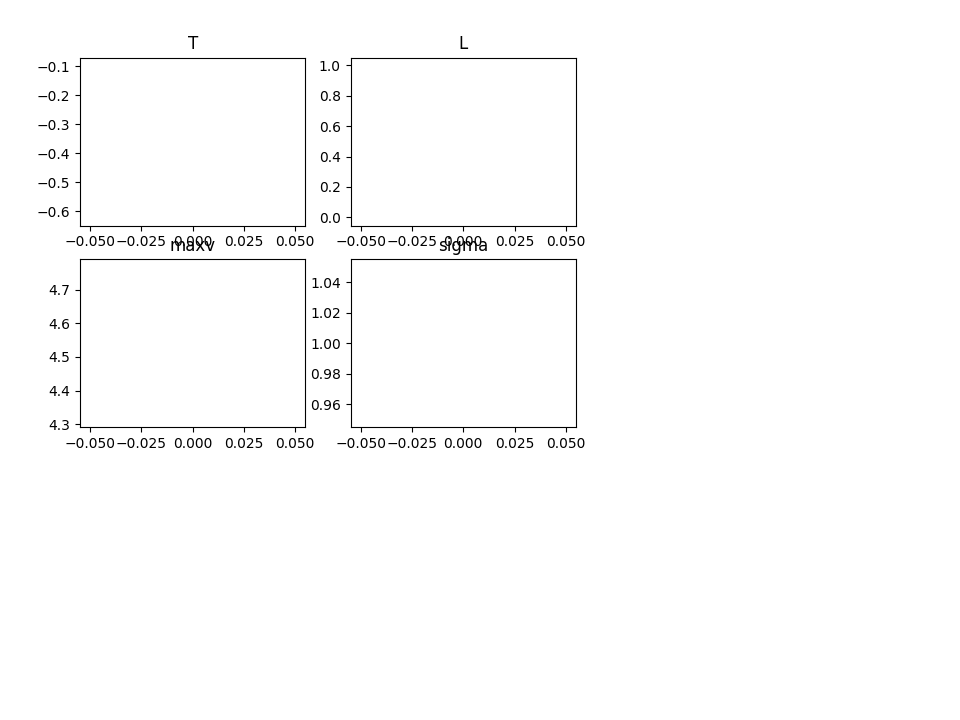

/mnt/data/csh_data/emlddmm/emlddmm.py:936: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figI = plt.figure()


<IPython.core.display.Javascript object>


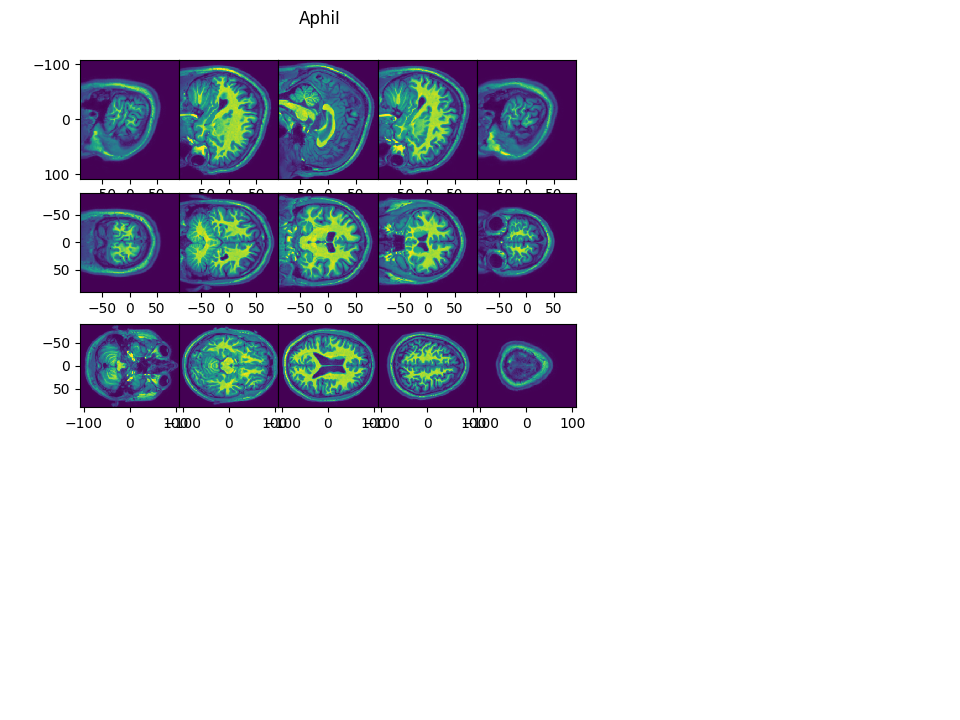

/mnt/data/csh_data/emlddmm/emlddmm.py:937: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figfI = plt.figure()


<IPython.core.display.Javascript object>


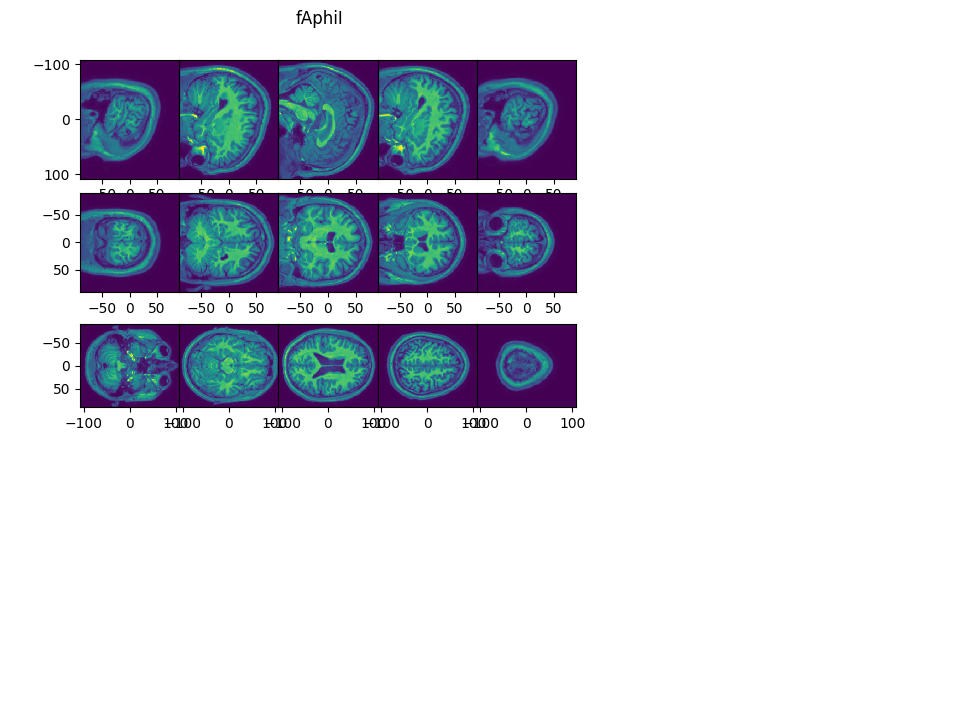

/mnt/data/csh_data/emlddmm/emlddmm.py:938: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figErr = plt.figure()


<IPython.core.display.Javascript object>


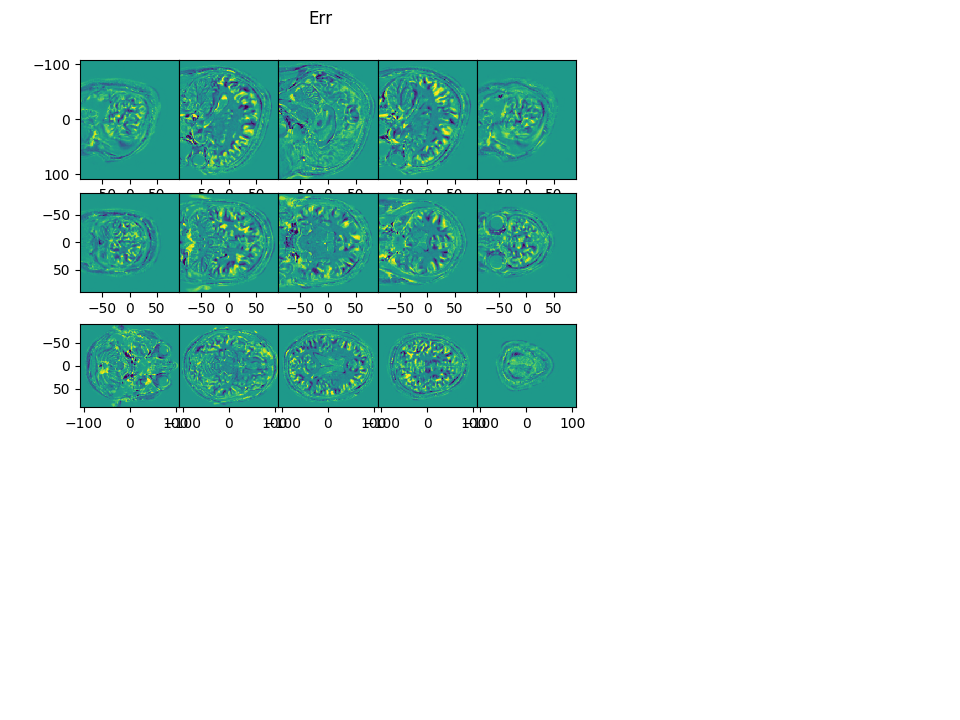

/mnt/data/csh_data/emlddmm/emlddmm.py:939: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figJ = plt.figure()


<IPython.core.display.Javascript object>


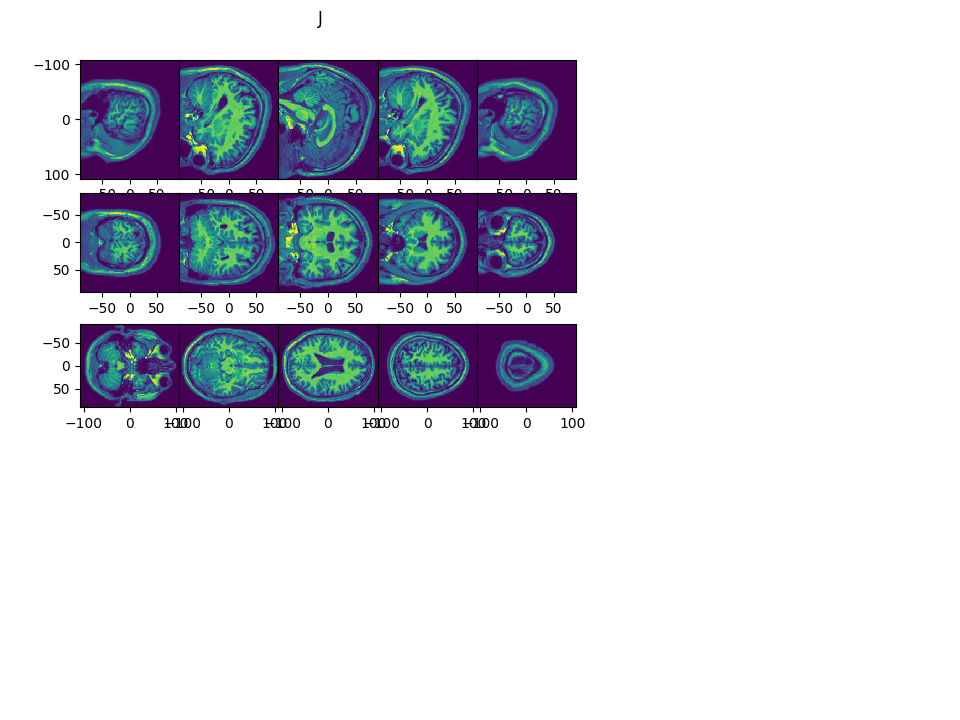

/mnt/data/csh_data/emlddmm/emlddmm.py:940: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figV = plt.figure()


<IPython.core.display.Javascript object>


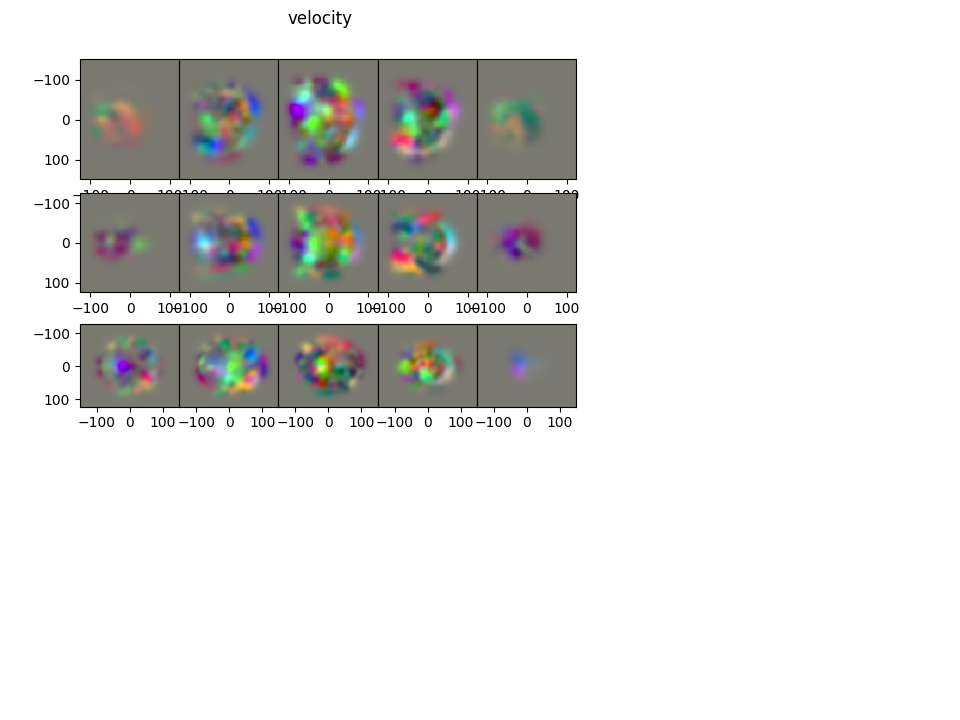

/mnt/data/csh_data/emlddmm/emlddmm.py:941: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figW = plt.figure()


<IPython.core.display.Javascript object>


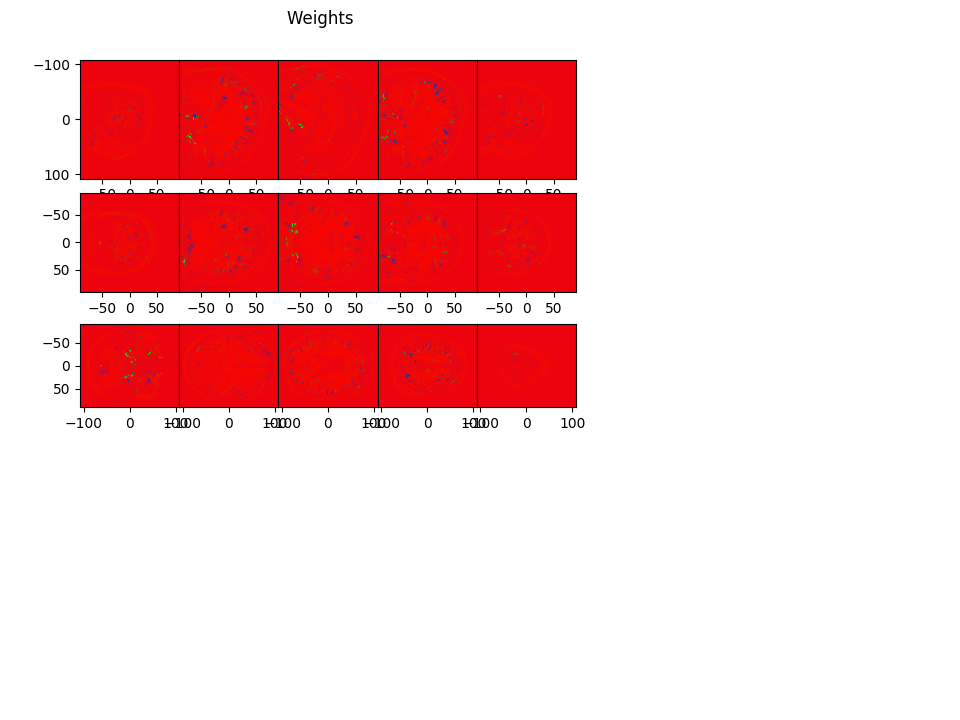

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30


In [ ]:
imp.reload(emlddmm)
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [ ]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

In [ ]:
# get labels
xS,S,title,names = emlddmm.read_data(label_name)

In [ ]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [ ]:
# test it, forward transform is used for computing a transformed target
# that is, visualize the target deformed to match the atlas
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

In [ ]:
import matplotlib.pyplot as plt
emlddmm.draw(Jt,xI)
plt.gcf().suptitle('Transformed target')

In [ ]:
# test it, backward transform is used for computing a transformed atlas
# that is, visualize the atlas deformed to match the target
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)
St = emlddmm.apply_transform_int(xS,S,Xout)

In [ ]:
# make a drawing of labels on the target
# get some colors for labels
labels,ids = np.unique(St,return_inverse=True)
colors = np.random.rand(len(labels),3)
RGB = colors[ids].reshape(St.shape[1],St.shape[2],St.shape[3],3).transpose(-1,0,1,2)

# compute boundaries
borders = St != torch.roll(St,1,1)
borders |= St != torch.roll(St,-1,1)
borders |= St != torch.roll(St,1,2)
borders |= St != torch.roll(St,-1,2)
borders |= St != torch.roll(St,1,3)
borders |= St != torch.roll(St,-1,3)
bordersRGB = borders*RGB
alpha = 0.8
emlddmm.draw(J/np.quantile(J,0.99)*(1.0 - borders*alpha).cpu().numpy() + bordersRGB.cpu().numpy()*alpha,xJ,n_slices=6)

In [ ]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [ ]:
# write out
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas.vtk'),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target.vtk'),xI,It,'atlas_to_target')
emlddmm.write_data(os.path.join(target_output_dir,'atlas_seg_to_target.vtk'),xI,St,'atlas_seg_to_target')